<h1 align="center">Project 3 - Model 04 - Using CountVectorizer</h1>


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline

#from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, f1_score

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.svm import SVC

from nltk.sentiment.vader import SentimentIntensityAnalyzer

### Read in Data

In [9]:
city_comp = pd.read_csv('data/city_comp.csv')
city_comp.head()

,subreddit,title,selftext,created_utc,text_length,text_word_count,classifier
0,houston,Want to build a stand alone apartment in backyard,Hello everyone. I want to build a stand alone ...,1630951521,640,122,0
1,houston,Relocating from Lex KY,Hi! Considering relocating from Lexington KY a...,1630948138,433,75,0
2,houston,Anywhere in Houston that can mount bindings to...,Just received some warranty replacement skis f...,1630943989,268,48,0
3,houston,Places to Study,Hi everyone! I just started school and I’m loo...,1630943452,197,35,0
4,houston,Where to buy fresh oysters( variety ),Well ass the tittle says is there anywhere in ...,1630941080,180,32,0


In [3]:
city_comp.shape

(11006, 7)

## Define X y and split the data

In [10]:
X = city_comp['selftext']
y = city_comp['classifier']


## Baseline

In [5]:
y.value_counts(normalize=True)

1    0.505633
0    0.494367
Name: classifier, dtype: float64

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify = y)


----

## CountVectorize - Add City Names to Stop_words

In [12]:
new_stop_words = list(CountVectorizer(stop_words='english').get_stop_words())

Ran one model with more words added to the stop word list and saw no large change.

In [13]:
new_stop_words.append('austin')
new_stop_words.append('houston')
#new_stop_words.append('im')
#new_stop_words.append('know')
#new_stop_words.append('just')
#new_stop_words.append('good')
#new_stop_words.append('like')
#new_stop_words.append('thanks')
#new_stop_words.append('610')


In [14]:
cvec_city = CountVectorizer(stop_words=new_stop_words)

In [15]:
X_train_cvec = cvec_city.fit_transform(X_train)
X_test_cvec = cvec_city.transform(X_test)

--------

## Logistic Regression

In [39]:
logreg_cv = LogisticRegressionCV(Cs=10, cv=5, penalty='l1', solver='liblinear', n_jobs=-1)
logreg_cv.fit(X_train_cvec, y_train)

print(logreg_cv.score(X_train_cvec, y_train))

print(logreg_cv.score(X_test_cvec, y_test))

0.9975769323964139
0.997093023255814


### Logistic Regression Feature Importance(Coef.)

In [43]:
pd.Series(logreg_cv.coef_.ravel(), cvec_city.get_feature_names()).sort_values(ascending=False).head(10)

assuming    6.989675
little      6.430970
hey         6.044143
south       5.397371
yall        4.898522
curious     4.812134
open        4.050332
question    3.737335
games       3.306832
floor       3.193121
dtype: float64

#### **Comment:** Ran a Logistic Regression 1st because it is a simple model and easy to test and wanted to see if everything worked with setting up a model to run.  Had very good results with high accuracy.  

#### Looked at the coeficients to see what words had the highest impact on the classification.  Was hoping to see some words that were big indications of which city to classify but did not.  Pretty common words were used.



In [ ]:
#Note: needed to use ravel to flatten the coef array.

-----

## Random Forest

In [12]:
#Instantiate the model
rf = RandomForestClassifier()

In [13]:
#Ran a cross validation score to see and estimated score
cross_val_score(rf, X_train_cvec, y_train, cv=5).mean()

0.9964866839197548

### Set up additional testing paramaters for the random forest

In [15]:
%%time
rf_params = {
    'n_estimators': [100, 150, 200],
    'max_depth': [None, 1, 2, 3, 4, 5],
    'max_features': ['sqrt', .5]
    
}
gs = GridSearchCV(rf, rf_params, cv=5, n_jobs= -1, verbose=1)
gs.fit(X_train_cvec, y_train)
print(gs.best_score_)
gs.best_params_

Fitting 5 folds for each of 36 candidates, totalling 180 fits
0.996486757337151
Wall time: 3min 18s


{'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 100}

In [15]:
gs.score(X_train_cvec, y_train)

1.0

In [16]:
gs.score(X_test_cvec, y_test)

0.9956395348837209

Look at the feature importance

In [16]:
pd.Series(gs.best_estimator_.feature_importances_, cvec_city.get_feature_names()).sort_values(ascending = False).head(10)

#pd.Series(gs.best_estimator_.feature_importances_).sort_values(ascending = False).head(10)

hey            0.020518
dog            0.016327
assuming       0.013908
curious        0.011719
im             0.011326
meet           0.009275
single         0.008894
day            0.008857
restaurants    0.008364
town           0.008285
dtype: float64

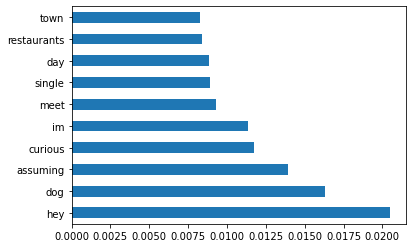

In [17]:
pd.Series(gs.best_estimator_.feature_importances_, cvec_city.get_feature_names()).sort_values(ascending = False).head(10).plot(kind='barh');

#### Again note the very high accuracy.  Next going to look at some specific text to investigate why such a high classification and what was missed.  First was to look at a confusion matrix.

In [20]:
#Looked at the f1 score, and it was high as expected.
preds = gs.predict(X_test_cvec)
f1_score(y_test, preds)

0.9956772334293948

In [28]:
# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

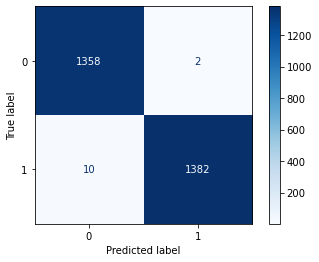

In [31]:
plot_confusion_matrix(gs, X_test_cvec, y_test, cmap='Blues', values_format='d')

#### Look at the text that was misclassified

In [57]:
#Need to pull the correct index from the the y_test for the dataframe
new_index = y_test.index

missed_classified = pd.DataFrame(gs.predict(X_test_cvec), columns=['predicted'], index=new_index)
missed_classified['actual'] = y_test
missed_classified.head()

Int64Index([ 1734,  8763,  2774,  7628,  3019,   317,  9247,  8197,  3272,
            10796,
            ...
             2923,  8712, 10944,   524,  4887,  3900,  8684,  5014,  6352,
             8605],
           dtype='int64', length=2752)

Below is a dataFrame of all the missclassified posts

In [59]:
missed_classified[missed_classified['predicted'] != missed_classified['actual']]

,predicted,actual
5465,0,1
5467,0,1
36,1,0
5445,0,1
5456,0,1
5468,0,1
5,1,0
5459,0,1
5442,0,1
5475,0,1


#### Since there are only 12 misclassified post I printed all of them out to read them and look for words that might have made them miss

In [66]:
missed_df = list(missed_classified[missed_classified['predicted'] != missed_classified['actual']].index)

In [67]:
missed_df

[5465, 5467, 36, 5445, 5456, 5468, 5, 5459, 5442, 5475, 5469, 5485]

### Note: numbers 36 and 5 guessed Austin and were Houston , the rest guessed Houston and were Austin

In [75]:
for i in missed_df:
    print(i)
    print(city_comp.iloc[i, 2])
    print()

5465
What’s a reputable, clean plasma donation center you trust in Austin? I’m looking into donating and the biggest place I’ve found is Biolife but the reviews sound horrible so I’m hesitant. Where have you had a great experience/experiences before?

5467
This is legal, so please dont remove.  I dont have my medical marijuana card yet, but meet with my oncologist again soon and plan to bring it up.  I have no interest in smoking it and honestly dont have the time or energy to make my own edibles.  So where can I get some?  Sorry, Im such a square, I wouldnt know where to start.

36
Have been trying my luck at freshwater fishing the past few weeks and have come up empty. I’ve been toe Dwight D park, Buffalo Run, and Tom Bass. Are there any other places to catch largemouth bass?

5445
I’m aware of the spots around Festival Beach but I live in south Austin and would love to avoid crossing the bridge if possible. Thanks for ideas!

5456
I noticed yesterday that the city put some speed bum

## Bonus: ran some additional models with different hyperparameters to look at the feature importance if anything stands out

In [22]:
%%time
# Grid search with CountVectorizer and Random Forest
# Instantiate pipeline object.
pipe_cvec = Pipeline([
    ('cvec', CountVectorizer(stop_words=new_stop_words)),
    ('rf', RandomForestClassifier())
    
])


pipe_cvec_params = {
    #'cvec__max_features': [2000, 3000, 4000, 5000], 
    'cvec__min_df': [1,2],
    'cvec__ngram_range': [(1,1), (1,2)],
    'rf__n_estimators': [100, 150, 200],
    'rf__max_depth': [None, 1, 2, 3, 4, 5],
    'rf__max_features': ['sqrt', .5]
}
pipe_cvec_gs = GridSearchCV(pipe_cvec, 
                                pipe_cvec_params,
                               n_jobs = -1,
                               verbose=1)


pipe_cvec_gs.fit(X_train, y_train)

print(pipe_cvec_gs.best_score_)

pipe_cvec_gs.best_params_

Fitting 5 folds for each of 144 candidates, totalling 720 fits
0.9968501000312024
Wall time: 11min


{'cvec__min_df': 1,
 'cvec__ngram_range': (1, 1),
 'rf__max_depth': None,
 'rf__max_features': 0.5,
 'rf__n_estimators': 100}

In [23]:
pipe_cvec_gs.score(X_train, y_train)

1.0

In [24]:
pipe_cvec_gs.score(X_test, y_test)

0.9956395348837209

In [25]:
len(pipe_cvec_gs.best_estimator_.named_steps['rf'].feature_importances_)

1993

In [26]:
len(pipe_cvec_gs.best_estimator_.named_steps['cvec'].get_feature_names())

1993

In [67]:
pipe_cvec_gs.best_estimator_.named_steps

{'cvec': CountVectorizer(min_df=2, ngram_range=(1, 2),
                 stop_words=['yourselves', 'hence', 'mill', 'around', 'few',
                             'nowhere', 'formerly', 'none', 'behind', 'already',
                             'thus', 'although', 'became', 'via', 'here', 'two',
                             'eleven', 'than', 'into', 'while', 'its', 'who',
                             'her', 'only', 'perhaps', 'an', 'neither',
                             'sometime', 'whose', 'done', ...]),
 'rf': RandomForestClassifier()}

In [27]:
pd.Series(pipe_cvec_gs.best_estimator_.named_steps['rf'].feature_importances_, pipe_cvec_gs.best_estimator_.named_steps['cvec'].get_feature_names()).sort_values(ascending = False).head(10)

hey          0.068812
dog          0.056855
assuming     0.054450
question     0.042210
tonight      0.032123
meet         0.029312
tradition    0.024558
park         0.024355
bars         0.021085
eating       0.019969
dtype: float64

## TFIDF Vectorizer

In [90]:
%%time

# Grid search with CountVectorizer and Random Forest
# Instantiate pipeline object.
pipe_tvec = Pipeline([
    ('tvec', TfidfVectorizer(stop_words=new_stop_words)),
    ('rf', RandomForestClassifier())
    
])


pipe_tvec_params = {
    #'cvec__max_features': [2000, 3000, 4000, 5000], 
    'tvec__min_df': [1,2],
    'tvec__ngram_range': [(1,1), (1,2)],
    'rf__n_estimators': [100, 150, 200],
    'rf__max_depth': [None, 1, 2, 3, 4, 5],
    'rf__max_features': ['sqrt', .5]
}
pipe_tvec_gs = GridSearchCV(pipe_tvec, 
                                pipe_tvec_params,
                               n_jobs = -1,
                               verbose=1)


pipe_tvec_gs.fit(X_train, y_train)

print(pipe_tvec_gs.best_score_)

pipe_tvec_gs.best_params_

Fitting 5 folds for each of 144 candidates, totalling 720 fits
0.9966079694583632
Wall time: 11min 24s


{'rf__max_depth': None,
 'rf__max_features': 'sqrt',
 'rf__n_estimators': 200,
 'tvec__min_df': 1,
 'tvec__ngram_range': (1, 2)}

In [91]:
pipe_tvec_gs.score(X_train, y_train)

1.0

In [92]:
pipe_tvec_gs.score(X_test, y_test)

0.9960029069767442

In [96]:
pd.Series(pipe_tvec_gs.best_estimator_.named_steps['rf'].feature_importances_, pipe_tvec_gs.best_estimator_.named_steps['tvec'].get_feature_names()).sort_values(ascending = False).head(20)

im              0.013394
like            0.012934
hey             0.012555
dog             0.011381
good            0.011201
open            0.009202
need            0.008520
place           0.008224
assuming        0.007673
right           0.007664
park            0.007317
know            0.007024
curious         0.006911
past            0.006886
town            0.006789
recently        0.006712
person          0.006119
stop            0.005854
meet            0.005573
looking good    0.005072
dtype: float64

# SVM

In [16]:
svc = SVC()

In [17]:
svc.fit(X_train_cvec, y_train)

SVC()

In [18]:
svc = SVC(kernel='poly', degree = 2)
svc.fit(X_train_cvec, y_train)
#y_pred = svc.predict(X_test)
print('train score: ', svc.score(X_train_cvec, y_train))
print('test score: ', svc.score(X_test_cvec, y_test))

train score:  0.9995153864792827
test score:  0.9967296511627907


In [21]:
#Could only find information on feature importance extraction for linear models
#ran out of time to figure out extracting features from poly kernel
#svc.coef_

In [26]:
pipe_svm = Pipeline([
    
    ('svm', SVC())
    
])

params = {
    'svm__kernel': ['sigmoid', 'poly'],
    'svm__degree': [2,3]
}


pipe_gs_svm = GridSearchCV(pipe_svm, params, cv=5, n_jobs= -1)
pipe_gs_svm.fit(X_train_cvec, y_train)

print(pipe_gs_svm.best_score_)
pipe_gs_svm.best_params_

0.9960020556870951


{'svm__degree': 2, 'svm__kernel': 'poly'}

In [22]:
#gs_svm.feature_importances_

In [28]:
#pd.Series(pipe_gs_svm.best_estimator_.named_steps['svm'].feature_importances_, pipe_gs_svm.best_estimator_.named_steps['svm'].get_feature_names()).sort_values(ascending = False).head(20)

# Sentiment Analysis

In [2]:
sent = SentimentIntensityAnalyzer()

In [5]:
sent.polarity_scores(city_comp.iloc[0, 2])

{'neg': 0.044, 'neu': 0.864, 'pos': 0.092, 'compound': 0.5805}

In [6]:
def get_sent(i, i_max):
    sum=0
    for num in range(i, i_max):
        v = sent.polarity_scores(city_comp.iloc[num, 2])
        sum += v['compound']
    return sum

In [7]:
#Houston Score
get_sent(0,5440)

1100.8948999999718

In [8]:
#Austin Score
get_sent(5441,11006)

1253.0389999999948

## Evaluation

Evaluation was done at the end of each model run, and compiled in a presentation.